# ASI assessed exercise 2016/2017
## 5th May 2017

In [1]:
import os
import struct
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import OrderedDict
from datetime import date

In [3]:
%matplotlib inline
import matplotlib.patches as mpatches
from numpy import linalg as lng
from collections import Counter

In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## 1. Download the MNIST and CIFAR10 datasets and import them. 

In [6]:
from keras.datasets import mnist
from keras.datasets import cifar10
 
# Load pre-shuffled MNIST data into train and test sets
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = mnist.load_data()
(cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test) = cifar10.load_data()
cifar_y_train = np.array([x[0] for x in cifar_y_train])
cifar_y_test = np.array([x[0] for x in cifar_y_test])

Using TensorFlow backend.


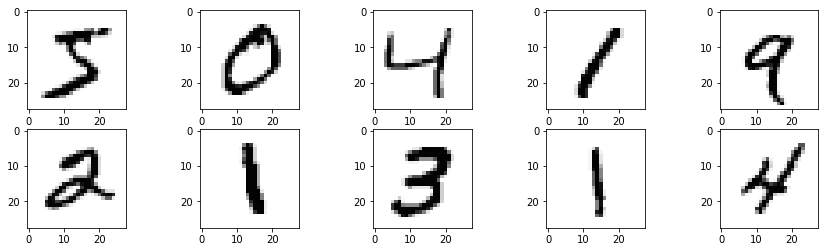

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [7]:
ROW = 2
COLUMN = 5
plt.figure(figsize=(15,4))
for i in range(ROW * COLUMN):
    image = mnist_X_train[i]
    plt.subplot(ROW, COLUMN, i+1)
    plt.imshow(image,cmap=mpl.cm.Greys)
plt.show()
mnist_y_train[:10]

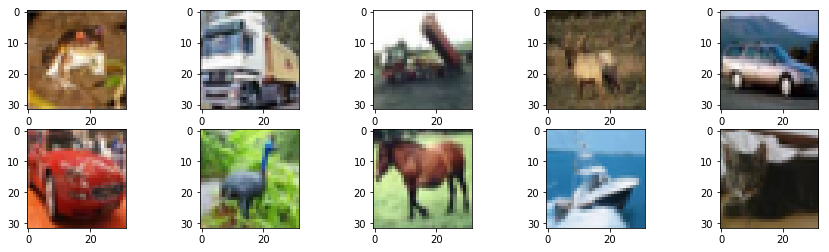

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3], dtype=uint8)

In [8]:
ROW = 2
COLUMN = 5
plt.figure(figsize=(15,4))
for i in range(ROW * COLUMN):
    image = cifar_x_train[i]
    plt.subplot(ROW, COLUMN, i+1)
    plt.imshow(image)
plt.show()
cifar_y_train[:10]

## 2. Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.

### Mnist

In [9]:
test_label = {'label': list([label for label in mnist_y_train])}
df = pd.DataFrame.from_dict(test_label)
counts_df = pd.DataFrame( df.groupby('label').size().rename('counts')).reset_index()

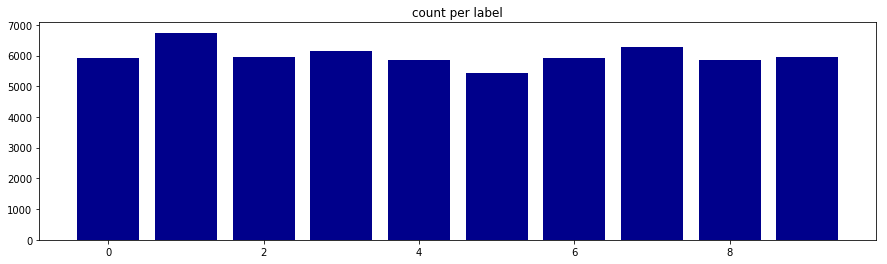

In [10]:
plt.figure(figsize=(15,4))
ax = plt.gca()
ax.bar('label','counts',data=counts_df,color='darkblue')
ax.set_title('count per label')
plt.show()

In [11]:
test_label = {'label': list([label for label in mnist_y_test])}
df = pd.DataFrame.from_dict(test_label)
counts_df = pd.DataFrame( df.groupby('label').size().rename('counts')).reset_index()

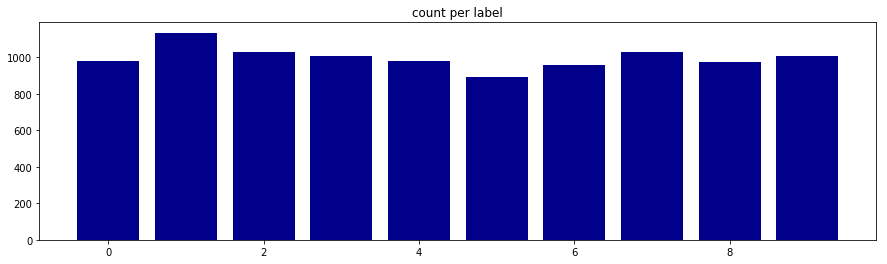

In [12]:
plt.figure(figsize=(15,4))
ax = plt.gca()
ax.bar('label','counts',data=counts_df,color='darkblue')
ax.set_title('count per label')
plt.show()

### Comment
Regarding the MNIST dataset, we can see that the images are more or less equally distributed among the different labels. We still see some differences, for example the label 1 has 6742 associated images, while the label 5 has 5421 associated images. This means that in our model the Prior will favour numbers with higher frequency, it would be stupid to not do that. Regarding this, we should try different priors and choose the best one.

Regarding the dimensionality of the images, they are 28*28 images in a scale of gray. Each pixel has values that goes from 0 to 255 and it may be wise to normalize them in order to not incur in math problems.

### Cifar

In [13]:
test_label = {'label': list([label for label in cifar_y_train])}
df = pd.DataFrame.from_dict(test_label)
counts_df = pd.DataFrame( df.groupby('label').size().rename('counts')).reset_index()

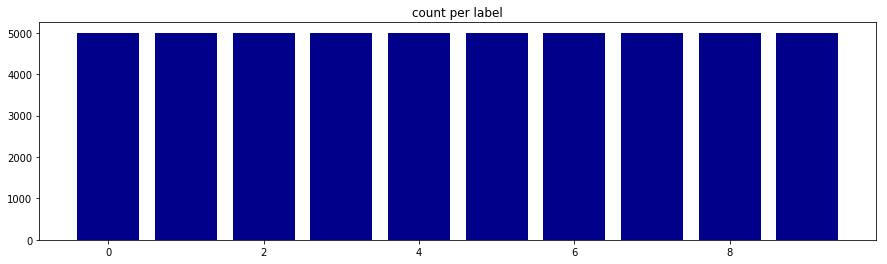

In [14]:
plt.figure(figsize=(15,4))
ax = plt.gca()
ax.bar('label','counts',data=counts_df,color='darkblue')
ax.set_title('count per label')
plt.show()

In [15]:
test_label = {'label': list([label for label in cifar_y_test])}
df = pd.DataFrame.from_dict(test_label)
counts_df = pd.DataFrame( df.groupby('label').size().rename('counts')).reset_index()

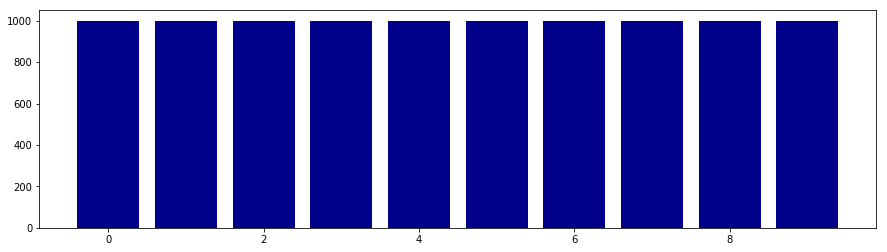

In [16]:
plt.figure(figsize=(15,4))
ax = plt.gca()
ax.bar('label','counts',data=counts_df,color='darkblue')
plt.show()

Here all labels have the same distribution, this means that we can use a constant prior for each of them. The dimensionality of the images is 3072, in fact they have 3 channels, this means that they are even more heavy to manipulate than the mnist numbers. The main problem will be to make our calculations fast and to not incur in overflows in the Naive Bayes.

## 3. Classification

## 3.a Implement the Naïve Bayes classifier. 

# Naive Bayes

In [17]:
import numpy as np
import scipy
import scipy.stats

class GaussianNaiveBayes:   
    def predict(self, data):
        results = [self.log_likelihood(data, label) for label in range(self.n_labels)]
        return np.argmax(results)
    
    def predict_prob(self, data):
        results = [self.log_likelihood(data, label) for label in range(self.n_labels)]
        total = scipy.misc.logsumexp(results)
        results = results - total
        return np.exp(results)

    def train(self, original_datas, labels):
        
        N = len(original_datas) # the number of training data
        datas = original_datas
        n_labels = len(set(labels))
        n_features = datas[0].shape[0]

        self.n_labels = int(n_labels)
        self.n_features = int(n_features)
        self.mean = np.zeros((n_labels, n_features), dtype=np.float128)
        self.var = np.zeros((n_labels, n_features), dtype=np.float128)
        self.prior = np.zeros(n_labels, dtype=np.float128)
        
        N_per_label = np.array([(labels == y).sum() for y in range(self.n_labels)], dtype=np.float) # count for each label
        # calculate mean of gaussians
        for label in range(self.n_labels):
            _sum = np.sum(datas[n] if labels[n] == label else 0.0 for n in range(N))
            self.mean[label] = _sum / N_per_label[label]
        # calculate variance of gaussians
        for label in range(self.n_labels):
            _sum = np.sum((datas[n] - self.mean[label])**2 if labels[n] == label else 0.0 for n in range(N))
            self.var[label] = _sum / N_per_label[label]

        # update prior of labels
        self.prior = N_per_label / N;
        
    def likelihood(self, data, label):
        #here we compute the numerator
        prior_label = self.prior[label]
        #log_posterior_data_given_label = -np.sum([self.log_gaussian_wrap(data[f], self.mean[label][f], self.var[label][f]) for f in range(self.n_features)])
        posterior_data_given_label = np.prod(self.gaussian_wrap(data, self.mean[label], self.var[label]))
        return prior_label * posterior_data_given_label

    def gaussian_wrap(self, x, mean, var):
        var += 1.0e-6
        return np.exp(- (x - mean)**2 / (2 * var) ) / np.sqrt(2 * var * np.pi)
        
    def log_likelihood(self, data, label):
        #here we compute the numerator
        log_prior_label = np.log(self.prior[label])
        #log_posterior_data_given_label = -np.sum([self.log_gaussian_wrap(data[f], self.mean[label][f], self.var[label][f]) for f in range(self.n_features)])
        log_posterior_data_given_label = np.sum(self.log_gaussian_wrap(data, self.mean[label], self.var[label]))
        return log_prior_label + log_posterior_data_given_label

    def log_gaussian_wrap(self, x, mean, var):
        var += 1.0e-6
        return  (- ((x - mean)**2) / (2 * var) ) - np.log(np.sqrt(2 * var * np.pi))

## 3.b Describe a positive and a negative feature of the classifier for these tasks

Since this is a classification problem, Naive Bayes seems the natural choice, since it is designed to do that, basically it chooses the best class based on the test data. Naive Bayes is Naive, which means that each feature is considered independently from the others. We cannot say that each pixel of an image is independent from the others. I think that this is the biggest limitaion, because we are limited with a model that cannot consider correlation between features.

## 3.c Describe any data pre-processing that you suggest for this data and your classifier

The main operation that we perform is the reshaping of the images, which are flattened. In this way we can consider each pixel as a feature and we can perform all operations using matrix and arrays.
Then, there are two problems: overflow and nan. In order to eliminate overflows we normalize all pixel values between 0 and 1.
Then we use 128 bit float numbers in order to perform more precise calculations, in fact when we multiply small values many times we obtain really small numbers that are casted to zero if the precision is not high enough. We have the same problem when we multiply large values.

## 3.d Apply your classifier to the two given datasets. Make sure your optimization is clearly commented. Use classification accuracy and test log-likelihood as your figures of merit 

In [18]:
NB = GaussianNaiveBayes()
mnist_X_train_flatten = np.array([x.flatten().astype(np.float128) / 255 for x in mnist_X_train])
mnist_X_test_flatten = np.array([x.flatten().astype(np.float128) / 255 for x in mnist_X_test])
NB.train(mnist_X_train_flatten,mnist_y_train)

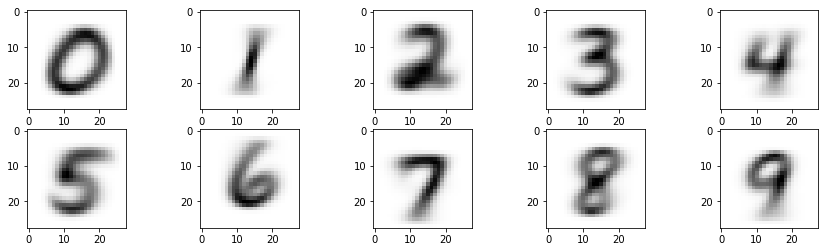

In [19]:
ROW = 2
COLUMN = 5
fig = plt.figure(figsize=(15,4))
for i in range(ROW * COLUMN):
    image = NB.mean[i].reshape(28,28).astype(np.float64)
    plt.subplot(ROW, COLUMN, i+1)
    plt.imshow(image, cmap=mpl.cm.Greys)
plt.show()

Looking at the mean number images, we see that each number is well defined inside the model. This is actually a good news because it means that we can differentiate well each number from the others

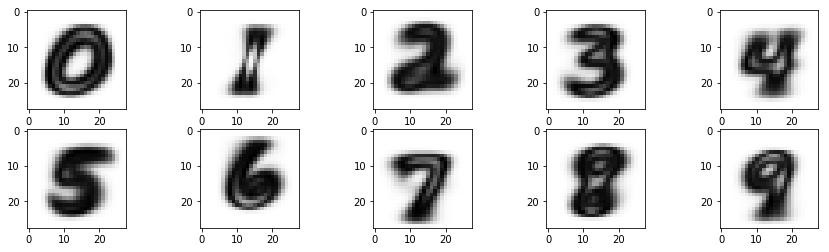

In [20]:
ROW = 2
COLUMN = 5
plt.figure(figsize=(15,4))
for i in range(ROW * COLUMN):
    image = NB.var[i].reshape(28,28).astype(np.float64)
    plt.subplot(ROW, COLUMN, i+1)
    plt.imshow(image, cmap=mpl.cm.Greys)
plt.show()

Looking at the variance, we see that it is higher at the borders of the number because those are the regions that vary the most

In [21]:
list_predict = []
predictions_prob = []
for i in range(len(mnist_X_test)):
    predicted = NB.predict(mnist_X_test_flatten[i])
    predictions_prob.append(NB.predict_prob(mnist_X_test_flatten[i]))
    list_predict.append((mnist_y_test[i],predicted))

In [22]:
true_predict = list(zip(*list_predict))
trues = true_predict[0]
predictions = true_predict[1]

In [24]:
prediction_p = [(np.argmax(x),x[int(np.argmax(x))])  for x in predictions_prob]
true_Positive_p = []
for i,x in enumerate(trues):
    if x == prediction_p[i][0]:
        true_Positive_p.append(prediction_p[i][1])
TP_confidence = np.mean(true_Positive_p)
print('True positive confidence is: %.3f' % TP_confidence)

True positive confidence is: 0.997


In [25]:
prediction_p = [(np.argmax(x),x[int(np.argmax(x))])  for x in predictions_prob]
false_Positive_p = []
for i,x in enumerate(trues):
    if x != prediction_p[i][0]:
        false_Positive_p.append(prediction_p[i][1])
FP_confidence = np.mean(false_Positive_p)
print('False positive confidence is: %.3f' % FP_confidence)

False positive confidence is: 0.982


In [103]:
accuracy = sklearn.metrics.accuracy_score(trues,predictions)
print('Mnist accuracy is: %.2f' % accuracy)

Mnist accuracy is: 0.81


In [23]:
loss = sklearn.metrics.log_loss(trues,predictions_prob)
print('Mnist log-loss is: %.2f' % loss)

Mnist log-loss is: 5.15


#### Optimizations:
Using an higher precision helps, but for example it does not work when in the bonus question we use 9216 features. In order to solve this problem, I did all calculations using logs. Calculations with logs are great because they are numerically stable. When it is not required to calculate probabilities I do not do it and I do not calculate the denominator of the prediction function.
Sometimes the variance is near to zero and calculations breaks. I solved this problem by adding a small variance to each pixel.
Since all calculations are vectorized, they are really fast.

## 3.e Display the confusion matrix on the test data

Confusion matrix, without normalization


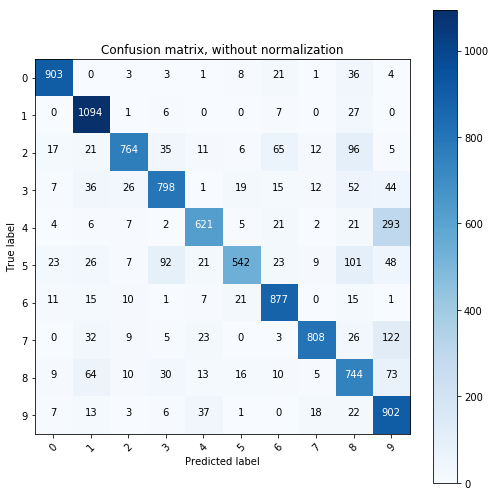

In [73]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(trues, predictions)
class_names=range(10) 
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

## 3.f Discuss the performance, compare them against a classifier that outputs random class labels, and suggest ways in which performance could be improved

In [74]:
def random_predict():
    return np.random.randint(low=0,high=9,size=1)
random_predictions = [random_predict() for x in trues]
accuracy = sklearn.metrics.accuracy_score(trues,random_predictions)
print('Mnist accuracy is: %.2f' % accuracy)

Mnist accuracy is: 0.11


As expected, a random classifier predicts at random, which in this case is 1/10

#### Naive Bayes Performances:
- I obtain an accuracy of 0.81, this is actually a good result.
- Regarding the true positive predictions, the confidence is 0.997
- Regarding the false positive predictions, the confidence is 0.982
- The log-loss is 5.15  

An high confidence for the true positives is good, because it means that when we make a correct prediction we are convinced of it.
An high confidence in the false positive is really bad, because now we cannot trust the confidence value of our model.
A log loss of 5.15 is quite high, it means that our model has low accuracy and bad confidence.
#### Improvements:
Naive Bayes is Naive because it makes the assumption that features are independent, but in this case they are not. In this optic, we can do PCA and obtain independent features in the hope that we can obtain a better accuracy.

# Cifar

In [40]:
cifar_x_train_flatten = np.array([x.flatten().astype(np.float128) / 255 for x in cifar_x_train])
cifar_x_test_flatten = np.array([x.flatten().astype(np.float128) / 255 for x in cifar_x_test])
NB = GaussianNaiveBayes()
NB.train(cifar_x_train_flatten,cifar_y_train)

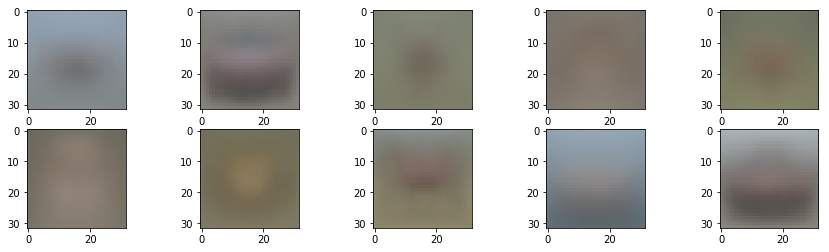

In [41]:
ROW = 2
COLUMN = 5
plt.figure(figsize=(15,4))
for i in range(ROW * COLUMN):
    image = NB.mean[i].reshape(32,32,3).astype(np.float64)
    plt.subplot(ROW, COLUMN, i+1)
    plt.imshow(image)
plt.show()

When we look at the mean image for each label, we see that we can hardly distinguish anything. I think that this means that the model will perform badly because it cannot differentiate between images.

In [42]:
list_predict = []
predictions_prob = []
for i in range(len(cifar_y_test)):
    predicted = NB.predict(cifar_x_test_flatten[i])
    predictions_prob.append(NB.predict_prob(cifar_x_test_flatten[i]))
    list_predict.append((cifar_y_test[i],predicted))


In [43]:
true_predict = list(zip(*list_predict))
trues = true_predict[0]
predictions = true_predict[1]

In [44]:
loss = sklearn.metrics.log_loss(trues,predictions_prob)
print('Mnist log-loss is: %.2f' % loss)

Mnist log-loss is: 23.88


In [45]:
prediction_p = [(np.argmax(x),x[int(np.argmax(x))])  for x in predictions_prob]
true_Positive_p = []
for i,x in enumerate(trues):
    if x == prediction_p[i][0]:
        true_Positive_p.append(prediction_p[i][1])
TP_confidence = np.mean(true_Positive_p)
print('True positive confidence is: %.3f' % TP_confidence)

True positive confidence is: 0.995


In [49]:
prediction_p = [(np.argmax(x),x[int(np.argmax(x))])  for x in predictions_prob]
false_Positive_p = []
for i,x in enumerate(trues):
    if x != prediction_p[i][0]:
        false_Positive_p.append(prediction_p[i][1])
FP_confidence = np.mean(false_Positive_p)
print('False positive confidence is: %.3f' % FP_confidence)

False positive confidence is: 0.995


In [47]:
accuracy = sklearn.metrics.accuracy_score(trues,predictions)
print('Cifar accuracy is: %.2f' % accuracy)

Cifar accuracy is: 0.28


Confusion matrix, without normalization


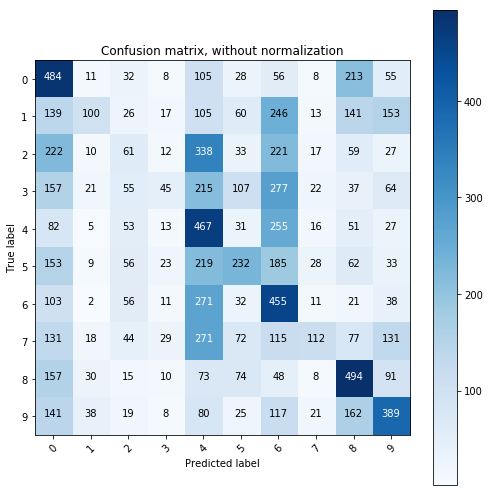

In [48]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(trues, predictions)
class_names=range(10) 
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

#### Naive Bayes Performances:
- I obtain an accuracy of 0.28, this is quite bad.
- Regarding the true positive predictions, the confidence is 0.995
- Regarding the false positive predictions, the confidence is 0.995
- The log-loss is 23.88  

As with mnist, we cannot trust confidence.  
If we look at the confusion matrix, we see that we can predict fairly well some classes, while we have problems with others. The fact that the behaviour is not the same for all the classes make me think that performances really depends from the training images. If images have a common pattern, then we can predict the correct label.

#### Improvements:
In this case i think that we obsolutely need to find the correlation between the 3 channels of the image, otherwise performances will be always poor.

# Linear Regression

In [50]:
X_train, X_test  = np.array([x.flatten() / 255 for x in mnist_X_train]), np.array([x.flatten()/255 for x in mnist_X_test]) # select the features
T_train, T_test = mnist_y_train, mnist_y_test # select the target

## 4.a Implement Bayesian linear regression (you should already have an implementation from the lab sessions) 

In [51]:
def linear_regression(X_train,X_test,grade=1,to_show=50):
    def calcMatPow(x,grade=1):
        '''
        calculate the matrix like [[x0^0,x0^1],[x1^0,x1^1]. . . . ]
        '''
        matrix = []
        for i in range(grade+1):
            matrix.append(np.power(x,i))
        return np.column_stack(matrix)
    
    def fit(X, T):
        X_tmp = np.dot(X.T, X)
        X_tmp += np.diag(np.random.random(len(X_tmp[0])))
        inv = np.linalg.inv(X_tmp)
        W = np.dot(np.dot(inv,X.T),T)
        return W,inv
    
    X_train = calcMatPow(X_train,grade)
    X_test = calcMatPow(X_test,grade)
    W,inv = fit(X_train, T_train)
    S = ((T_train-X_train.dot(W)).T).dot(((T_train-X_train.dot(W)).T))/len(X_train)
    #print(S)
    
    to_show = to_show
    #sigma_square_new = []
    inv = np.matrix(inv)
    #for xnew in X_test[:to_show]:
    #    xnew = xnew.reshape(-1,1)
    #    sigma_square_new.append((S*xnew.T*inv*xnew)[0,0])
    sigma_square_new = np.diag(X_test*inv*X_test.T) + S
    
    predictions = np.round(np.dot(X_test, W))
    return predictions,sigma_square_new

## 4.b Treat class labels as continuous and apply regression to the training data.

In the dataset that I downloaded, class labels are integers, so they can already be treated as continuous. If we were provided with strings, then we would have had to convert them to integer numbers.

In [52]:
to_show = 50
predictions, sigma_square_new = linear_regression(X_train,X_test,grade=2,to_show=to_show)

For each xnew compute the predictive variance:

$$\sigma_{new}^2 = \sigma^2 + x_{new}^T (X^T X)^{-1}x_{new}$$

## 4.c Produce a scatter plot showing the predictions versus the true targets for the test set and compute the mean squared error on the test set

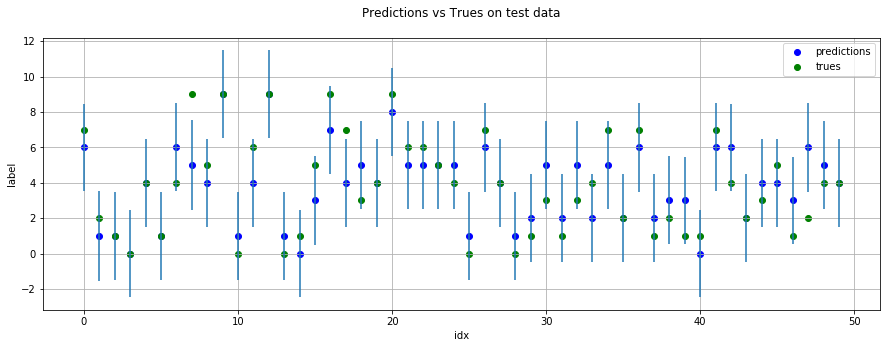

In [53]:
trues = T_test
plt.figure(figsize=(15,5))
# Plotting

plt.scatter(list(range(to_show)), predictions[:to_show], color="blue")
plt.scatter(list(range(to_show)), trues[:to_show], color="green")
plt.errorbar(list(range(to_show)), predictions[:to_show], yerr=sigma_square_new[:to_show],fmt=' ')  


plt.title("Predictions vs Trues on test data\n")
plt.xlabel("idx")
plt.ylabel("label")
plt.legend(['predictions','trues'])
plt.grid()
plt.show()

In [35]:
error = np.sum([(predictions[i]-trues[i])**2 for i in range(len(predictions))]) / len(predictions)
print('MSE is: %.2f' % error)

2.5499000000000001

## 4.d Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy

In [58]:
new_predictions = np.array([0 if x < 0 else x for x in predictions ])
new_predictions = np.array([9 if x > 9 else x for x in new_predictions ])
new_predictions = np.round(new_predictions)

Confusion matrix, without normalization


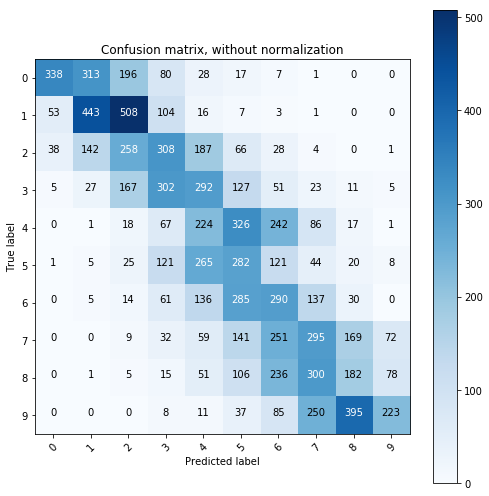

In [59]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(trues, new_predictions)
class_names=range(10) 
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

In [60]:
accuracy = sklearn.metrics.accuracy_score(trues,new_predictions)
print('Mnist accuracy is: %.2f' % accuracy)

Mnist accuracy is: 0.28


### Comment:
Here I collapsed all predictions > 9 to 9, and all predictions < 0 to 0.
Then, I rounded to the nearest integer. This looks the most intuitive thing to do.
I also tried to take the floor and got better accuracy, but There is no way to justify it.

## 4.e Discuss regression performance with respect to classification performance

Here I intend the question as: compare the results obtained with the naive bayes classifier and those obtained with the bayesian linear regression.
- Naive bayes classifier is more accurate.
- Both models cannot give us a confidence that we can trust.
- Required time: In this case the Naive Bayes wins

## 4.f Describe one limitation of using regression for this particular task. 

Linear regression should be used to do regressions. e.g. predict a continue value from a series. It can be used also for classification, but in this case we obtain bad results.

# Cifar

In [ ]:
X_train, X_test  = np.array([x.flatten() / 255 for x in cifar_x_train]), np.array([x.flatten()/255 for x in cifar_x_test]) # select the features
T_train, T_test = cifar_y_train, cifar_y_test # select the target

In [ ]:
predictions, sigma_square_new = linear_regression(X_train,X_test,grade=2,to_show=50)

In [ ]:
trues = T_test
plt.figure(figsize=(15,5))
# Plotting
to_show = 50
plt.scatter(list(range(to_show)), predictions[:to_show], color="blue")
plt.errorbar(list(range(to_show)), predictions[:to_show], yerr=sigma_square_new[:to_show],fmt=' ')  
plt.scatter(list(range(to_show)), trues[:to_show], color="green")

plt.title("Predictions vs Trues on test data\n")
plt.xlabel("idx")
plt.ylabel("label")
plt.grid()
plt.show()

In [ ]:
error = np.sum([(predictions[i]-trues[i])**2 for i in range(len(predictions))]) / len(predictions)
error

In [ ]:
new_predictions = np.array([0 if x < 0 else x for x in predictions ])
new_predictions = np.array([9 if x > 9 else x for x in new_predictions ])
new_predictions = np.round(new_predictions)

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(trues, new_predictions)
class_names=range(10) 
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
accuracy = sklearn.metrics.accuracy_score(trues,new_predictions)
print('Mnist accuracy is: %.2f' % accuracy)

# Bonus question
The state-of-the-art in these image classification problems suggests that
convolutional layers in convolutional neural networks yield most of the improvements
compared to standard neural networks. The reason is that they are capable of
modeling spatial patterns through the hierarchical analysis of patches of images.
Propose and implement ways to exploit patch information in the Naïve Bayes
classifier or linear regression. A couple of suggestions are: (i) apply Naïve Bayes
classification to the output of convolutional layer in the LeNet architecture (ii) construct
the Naïve Bayes classifier by calculating patch-specific statistics and extend this by
stacking multiple of these

### Comment
Here I decided to apply Naïve Bayes classification to the output of convolutional layer in the LeNet architecture. I did this because I ahve already seen the power of convolutional neural networks with this dataset and I think that it is the most straightforward way. Then, it is interesting to see the result of combining two models.

In [37]:
# https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 4

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_vec = keras.utils.to_categorical(y_train, num_classes)
y_test_vec = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train_vec,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test_vec))
score = model.evaluate(x_test, y_test_vec, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 224s - loss: 0.3479 - acc: 0.8939 - val_loss: 0.0829 - val_acc: 0.9743

In [38]:
from keras.models import Model

layer_name = 'flatten'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_train = intermediate_layer_model.predict(x_train)
intermediate_test = intermediate_layer_model.predict(x_test)
intermediate_train.shape

(60000, 9216)

### Train Naive Bayes

In [40]:
NB = GaussianNaiveBayes()
NB.train(intermediate_train,y_train)

In [41]:
list_predict = []
predictions_prob = []
for i in range(len(intermediate_test)):
    predicted = NB.predict(intermediate_test[i])
    predictions_prob.append(NB.predict_prob(intermediate_test[i]))
    list_predict.append((y_test[i],predicted))

In [42]:
true_predict = list(zip(*list_predict))
trues = true_predict[0]
predictions = true_predict[1]

In [43]:
accuracy = sklearn.metrics.accuracy_score(trues,predictions)
print('Mnist accuracy is: %.2f' % accuracy)

Mnist accuracy is: 0.94


In [44]:
loss = sklearn.metrics.log_loss(trues,predictions_prob)
print('Mnist log-loss is: %.2f' % loss)

Mnist log-loss is: 2.09


In [45]:
prediction_p = [(np.argmax(x),x[int(np.argmax(x))])  for x in predictions_prob]
true_Positive_p = []
for i,x in enumerate(trues):
    if x == prediction_p[i][0]:
        true_Positive_p.append(prediction_p[i][1])
np.mean(true_Positive_p)

0.99998938611243828525

In [46]:
prediction_p = [(np.argmax(x),x[int(np.argmax(x))])  for x in predictions_prob]
false_Positive_p = []
for i,x in enumerate(trues):
    if x != prediction_p[i][0]:
        false_Positive_p.append(prediction_p[i][1])
np.mean(false_Positive_p)

0.99981353029234412661

### Comment
We see that we obtained a way better accuracy. The problem is that we still obtain a lower accuracy when we compare the result to the LeNet5_only.
  
`0.9877` vs `0.94`

When we look at the dimensionality of the output of the convolutional layer, we have 9216 features. At this point we basically have expanded the dimensionality of our image by considering the convolutions of near pixels.
The main considerations that we can do are:
- The features that we obtain can be considered independent?  
**Answer**: I think that the features cannot be considered as independent, because during the convolutional steps, filters overlap.
- The dimensionality is very high, can Naive Bayes model such a complex problem?  
**Answer**: At the end we managed to obtain a good accuracy, so there is some potential. In any case, since the NN still performs better, I can state that also with the Naive Bayes, most of the merit for the high score should be attributed to the convolutional layer of the NN.
- What is the advantage of Naive Bayes?  
**Answer**: It can give us probabilities associated to each label, in this optic the Naive Bayes is superior to the Neural Network.
- Probabilities given by the classifier are reliable?  
**Answer**: No, in fact we have high confidence also when we make a mistake, basically we cannot trust the probabilities given. The log-loss is lower because in this case the accuracy is way higher.